# Assignment 2
# Data Pipelines & Data Analytics Life Cycle
# Forecasting the Wind Power Production in Orkney

#### Environment and Libraries

### Setting up the environment with `venv`

It is always recommended to create a new environment for any new project to avoid dependency issues and keep a clean working space. 

Step 1: Create a virtual environment in your project directory:

python3.11 -m venv .venv


Step 2: Activate the virtual environment:  
For Linux/Mac:  
source .venv/bin/activate  


For Windows:  
.venv\Scripts\activate  


Step 3: Install the required libraries using requirements.txt from https://github.itu.dk/Big-Data-Management-2025/python_env

pip install -r requirements.txt

Once your environment is set up and dependencies are installed, you are ready to proceed with your project.



### Imports

In [ ]:
# You absolutely need these
import mlflow

# You will probably need these
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline

# This are for example purposes. You may discard them if you don't use them.
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
from mlflow.models import infer_signature
from urllib.parse import urlparse

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor 
import mlflow, mlflow.sklearn


## Step 1: The Data

In [2]:
power_df = pd.read_csv('data/power.csv', parse_dates=["time"], index_col="time")
wind_df = pd.read_csv('data/weather.csv', parse_dates=["time"], index_col="time")

Let's take a look at the resulting dataframes:

In [3]:
power_df.head()

,ANM,Non-ANM,Total
time,,,
2021-12-11 13:39:00+00:00,10.195558,17.102,27.297558
2021-12-11 13:40:00+00:00,10.043559,17.582,27.625559
2021-12-11 13:41:00+00:00,10.961558,17.139,28.100558
2021-12-11 13:42:00+00:00,11.240559,16.194,27.434559
2021-12-11 13:43:00+00:00,10.672559,16.566,27.238559


**NOTE:** <em>This table contains three columns, but closer inspection will reveal a very straigh relationship between those three. Can you spot that?<br>
We are clearly interested in the total power generation, regardless of the source type.</em>

Total = ANM + Non-ANM (e.g. 10.195558 + 17.102 = 27.297558). 

In [4]:
wind_df.head()

,Direction,Lead_hours,Source_time,Speed
time,,,,
2021-12-11 15:00:00+00:00,SSE,1,1639227600,11.17600
2021-12-11 18:00:00+00:00,SSW,1,1639238400,8.04672
2021-12-11 21:00:00+00:00,WSW,1,1639249200,11.17600
2021-12-12 00:00:00+00:00,WSW,1,1639260000,8.94080
2021-12-12 03:00:00+00:00,SW,1,1639270800,9.83488


**NOTE:** <em>This table contains four columns, but lead hours and source time are irrelevant here. Can you think why?</em>

**NOTE:** <em>Look at the table's index. Do both data sources contain the same intervals? And if not, what problems could arise when merging the data?</em>

Lead_hours is constant and Source_time is the same as time (already given as the index) but encoded as UNIX seconds. 

The first table is minute-level (e.g. 13:39,13:40…), the second is 3-hourly (15:00,18:00…), so they do NOT share the same intervals.
* May arrise problems when doing inner-join, many dropped rows due to the index not being the same.

### Merging the data sources

We have two dataframes, one with weather forecast and one with power generation. To do some analysis on the relationship between these two datasets, it might be useful to join (and align) the data.

#### Example

In [5]:
joined_dfs = power_df.join(wind_df, how="inner")

# Filtrate power_dfs and wind_dfs to not include Lead_hours, Source_time and ANM and Non-AMN (as these can be reflected in total)
cols_to_drop_power = [c for c in ['ANM','Non-ANM'] if c in power_df.columns]
cols_to_drop_wind = [c for c in ['Lead_hours','Source_time'] if c in wind_df.columns]
power_df.drop(columns=cols_to_drop_power, inplace=True, errors='ignore')
wind_df.drop(columns=cols_to_drop_wind, inplace=True, errors='ignore')

# Joining the data
inner_join_dfs = power_df.join(wind_df, how="inner")


Joining the two datasets with an inner join means keeping only those records that match their index. Although this will work, you may notice that most of our data is discarded due to the unmatching time intervals. You may want to explore other possible ways to merge the data.

In [7]:
#Upsampling weather data
wind_1h_dfs = wind_df.resample('1min').ffill()
upsampled_join_dfs = wind_1h_dfs.join(power_df, how="inner")
upsampled_join_dfs.head()




,Direction,Speed,Total
time,,,
2021-12-11 15:00:00+00:00,SSE,11.176,27.864560
2021-12-11 15:01:00+00:00,SSE,11.176,28.489561
2021-12-11 15:02:00+00:00,SSE,11.176,28.150561
2021-12-11 15:03:00+00:00,SSE,11.176,26.634557
2021-12-11 15:04:00+00:00,SSE,11.176,26.172559


In [8]:

#Downsampling power data
power_3h_dfs = power_df.resample('3h').mean()
downsampled_join_dfs = power_3h_dfs.join(wind_df, how='inner')
downsampled_join_dfs.head()

,Total,Direction,Speed
time,,,
2021-12-11 15:00:00+00:00,27.621048,SSE,11.17600
2021-12-11 18:00:00+00:00,21.135542,SSW,8.04672
2021-12-11 21:00:00+00:00,20.616209,WSW,11.17600
2021-12-12 00:00:00+00:00,21.223876,WSW,8.94080
2021-12-12 03:00:00+00:00,19.418303,SW,9.83488


In [9]:
merge = pd.merge_asof(power_df, wind_df, on='time', direction='nearest', tolerance=pd.Timedelta('90min'))
merged_wind_power_dfs = merge.set_index('time')
merged_wind_power_dfs.head()

,Total,Direction,Speed
time,,,
2021-12-11 13:39:00+00:00,27.297558,SSE,11.176
2021-12-11 13:40:00+00:00,27.625559,SSE,11.176
2021-12-11 13:41:00+00:00,28.100558,SSE,11.176
2021-12-11 13:42:00+00:00,27.434559,SSE,11.176
2021-12-11 13:43:00+00:00,27.238559,SSE,11.176


### Understanding the data: EDA

It can be also useful to plot our datasets to see what relationships they might hold.

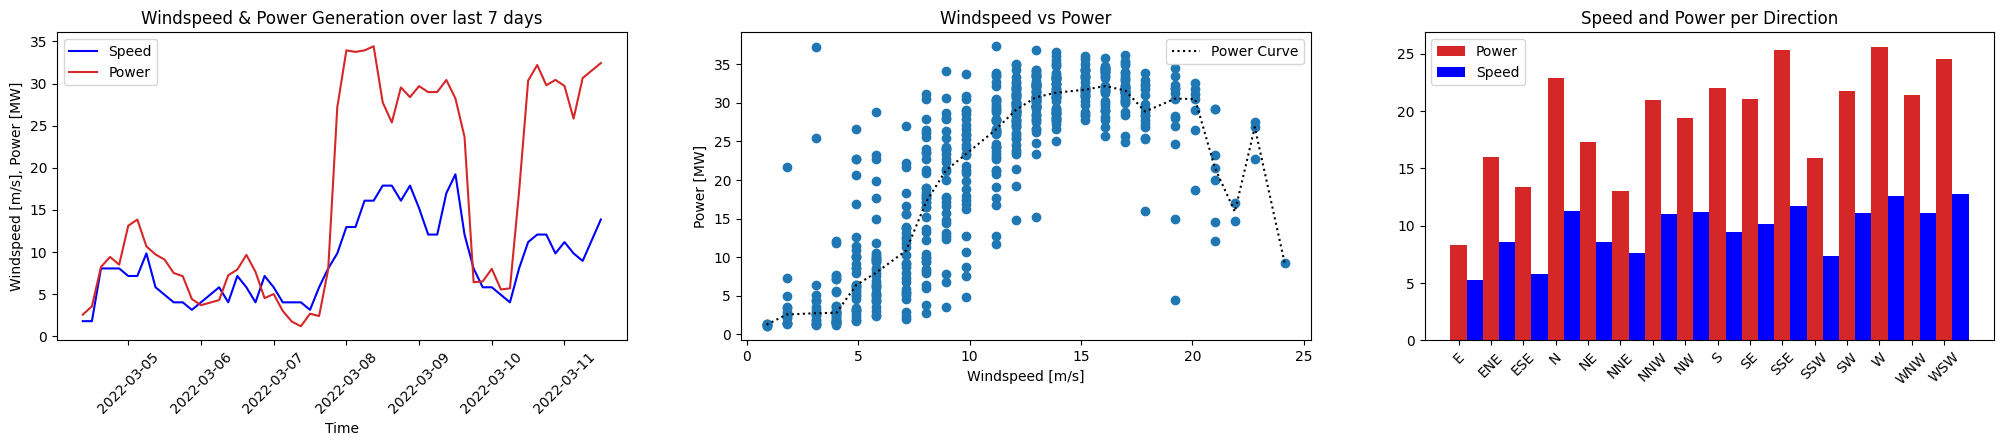

In [10]:
# Subplots
fig, ax = plt.subplots(1,3, figsize=(25,4))

# Speed and Power for the last 7 days
ax[0].plot(joined_dfs["Speed"].tail(int(7*24/3)), label="Speed", color="blue") # Since the datasets are joined every three hours, we need the last 7 days times 24 hours diveded by 3 hours
ax[0].plot(joined_dfs["Total"].tail(int(7*24/3)), label="Power", color="tab:red") # Since the datasets are joined every three hours, we need the last 7 days times 24 hours diveded by 3 hours
ax[0].set_title("Windspeed & Power Generation over last 7 days")
ax[0].set_xlabel("Time")
ax[0].tick_params(axis='x', labelrotation = 45)
ax[0].set_ylabel("Windspeed [m/s], Power [MW]")
ax[0].legend()

# Speed vs Total (Power Curve nature)
ax[1].scatter(joined_dfs["Speed"], joined_dfs["Total"])
power_curve = joined_dfs.groupby("Speed").median(numeric_only=True)["Total"]
ax[1].plot(power_curve.index, power_curve.values, "k:", label="Power Curve")
ax[1].legend()
ax[1].set_title("Windspeed vs Power")
ax[1].set_ylabel("Power [MW]")
ax[1].set_xlabel("Windspeed [m/s]")

# Speed and Power per Wind Direction
wind_grouped_by_direction = joined_dfs.groupby("Direction").mean(numeric_only=True).reset_index()
bar_width = 0.5
x = np.arange(len(wind_grouped_by_direction.index))

ax[2].bar(x, wind_grouped_by_direction.Total, width=0.5, label="Power", color="tab:red")
ax[2].bar(x + bar_width, wind_grouped_by_direction.Speed, width=0.5, label="Speed", color="blue")
ax[2].legend()
ax[2].set_xticks(x)
ax[2].set_xticklabels(wind_grouped_by_direction.Direction)
ax[2].tick_params(axis='x', labelrotation = 45)
ax[2].set_title("Speed and Power per Direction");

**NOTE:** <em>These plots should already give us an intuition of the different relationships between features. It seems clear that there is a positive relationship between the wind speed and the power generation from the turbines, as we obviously suspected. But that relationship is not completely linear. Can you spot that? Finally, it seems like the power generation also depends of where the winds is coming from. Maybe this could also be a useful feature.</em> 

* wind speed shows a positive but clearly nonlinear effect on power, and wind direction also influences output so include it as a circular (or categorical) feature.

In order to plot the relationship between wind speed and power generation we have performed a very simple join with the two datasets. But since the intervals are not the same, a lot of data is discarded (<em>can you spot where in the code this happens?</em>). You may want to explore other ways to merge the data sources to minimize the loss of information.

* The data is lost at inner_join_dfs = power_df.join(wind_df, how="inner") — using how='inner' drops all timestamps not present in both DataFrames
* I have merged the data as follows: upsample, downsample and merge asof (nearest within tolerance)

### Encode the weather direction

**Problem**: I could use a simple encoding (one hot vector) where I map the direction to a value from 0 to 15, or map them to a degree from 0 to 360. However doing this gives me a problem, for example, the value 1 and 15 or 0 and 350, will be totally different in terms of the distance between them, making these features very distinct. But in reality these feature might represent similarities, since they both might represent a close or similar direction. 

In short, it removes the circular relationship between them, example N or NNW are physically close, but N and S should be far apart.

**Solution**: I map the direction to a degree (sixteen values), which corresponds to the azimuth angle. To handle the circularity I further encode them to sine and cosine representations.

**Alternative**: I also try to see if combining the speed and direction into a vector.

In [11]:
import numpy as np

compass_directions = ['N','NNE','NE','ENE','E','ESE','SE','SSE',
                      'S','SSW','SW','WSW','W','WNW','NW','NNW']
degree_map = {k: i * 22.5 for i, k in enumerate(compass_directions)}

for df in [inner_join_dfs, upsampled_join_dfs, downsampled_join_dfs, merged_wind_power_dfs]:
    df['Degree'] = df['Direction'].map(degree_map)

def add_sin_cos(df):
    df = df.copy()
    df['Radians'] = np.deg2rad(df['Degree'])
    df['Sin'] = np.sin(df['Radians'])
    df['Cos'] = np.cos(df['Radians'])
    df = df.drop(columns=['Radians', 'Direction', 'Degree'], errors='ignore')
    return df

def wind_vector(df):
    df = add_sin_cos(df.copy())
    df['u'] = df['Speed'] * df['Sin']
    df['v'] = df['Speed'] * df['Cos']
    df = df.drop(columns=['Sin', 'Cos', 'Radians', 'Direction', 'Degree'], errors='ignore')
    return df

sincos_inner = add_sin_cos(inner_join_dfs.copy())
sincos_upsampled = add_sin_cos(upsampled_join_dfs.copy())
sincos_downsampled = add_sin_cos(downsampled_join_dfs.copy())
sincos_merged = add_sin_cos(merged_wind_power_dfs.copy())

wind_vector_inner = wind_vector(inner_join_dfs.copy())
wind_vector_upsampled = wind_vector(upsampled_join_dfs.copy())
wind_vector_downsampled = wind_vector(downsampled_join_dfs.copy())
wind_vector_merged = wind_vector(merged_wind_power_dfs.copy())


In [12]:
sincos_inner.head()

,Total,Speed,Sin,Cos
time,,,,
2021-12-11 15:00:00+00:00,27.864560,11.17600,0.382683,-0.923880
2021-12-11 18:00:00+00:00,26.091558,8.04672,-0.382683,-0.923880
2021-12-11 21:00:00+00:00,16.727561,11.17600,-0.923880,-0.382683
2021-12-12 00:00:00+00:00,21.364559,8.94080,-0.923880,-0.382683
2021-12-12 03:00:00+00:00,21.231557,9.83488,-0.707107,-0.707107


In [13]:
wind_vector_inner.head()

,Total,Speed,u,v
time,,,,
2021-12-11 15:00:00+00:00,27.864560,11.17600,4.276870,-10.325278
2021-12-11 18:00:00+00:00,26.091558,8.04672,-3.079346,-7.434200
2021-12-11 21:00:00+00:00,16.727561,11.17600,-10.325278,-4.276870
2021-12-12 00:00:00+00:00,21.364559,8.94080,-8.260222,-3.421496
2021-12-12 03:00:00+00:00,21.231557,9.83488,-6.954310,-6.954310


## Step 2: Pipeline and data transformations

Now that we have our data, we need to construct the pipeline to process this data and pass it to our Machine Learning model. For this, you may find useful the Pipeline class from Scikit-Learn.

This class applies a list of transforms to your data, and pass the final state to an estimator (your model). Intermediate steps of the pipeline must be ‘transforms’, that is, they must implement fit and transform methods. The final estimator only needs to implement fit. 

The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters. For this, it enables setting parameters of the various steps using their names and the parameter name separated by a '__'. 

You can find more information about Scikit-Learn's Pipeline [here](https://scikit-learn.org/stable/modules/compose.html#pipeline).

#### Example

In [14]:
# A very basic pipeline
pipeline_example = Pipeline([
    # Transformations
    ("Scaler", StandardScaler()),
    # Estimator
    ("Linear Regression", LinearRegression())
])

### Creating my own pipeline

In [ ]:
# Keep in mind the MlFlow part: the grid search, is technically a waste of time. 
# That's what it will do for you, as it compares it for you side by side
# Create your pipeline with the desired transformersr 

def candidate_models():
    models = {
        'linear': LinearRegression(),
        'rf': RandomForestRegressor(n_estimators=100, random_state=42),
        'gbr': GradientBoostingRegressor(n_estimators=100, random_state=42),
        'xgb': XGBRegressor(n_estimators=100, random_state=42, verbosity=0),
    }
    return models

def add_sin_cos(df):
    df = df.copy()
    df['Radians'] = np.deg2rad(df['Degree'])
    df['Sin'] = np.sin(df['Radians'])
    df['Cos'] = np.cos(df['Radians'])
    df = df.drop(columns=['Radians', 'Direction', 'Degree'], errors='ignore')
    return df

def add_wind_vector(df):
    df = add_sin_cos(df.copy())
    df['u'] = df['Speed'] * df['Sin']
    df['v'] = df['Speed'] * df['Cos']
    df = df.drop(columns=['Sin', 'Cos', 'Radians', 'Direction', 'Degree'], errors='ignore')
    return df

datasets = {
    "Inner_Join_SinCos": sincos_inner,
    "Upsampled_SinCos": sincos_upsampled,
    "Downsampled_SinCos": sincos_downsampled,
    "Merged_SinCos": sincos_merged,
    "Inner_Join_WindVector": wind_vector_inner,
    "Upsampled_WindVector": wind_vector_upsampled,
    "Downsampled_WindVector": wind_vector_downsampled,
    "Merged_WindVector": wind_vector_merged,
}

sincos_X = ['Cos', 'Sin'] # SinCos Features
windvector_X = ['u', 'v'] # WindVector Features
y = ['Total'] # Label



def train_model(df, name, models, features, label, experiment_name):
    
    mlflow.set_experiment(experiment_name)
    
    X = df[features]
    y = df[label]

    # Chronological Split for train and test sets: 80% to 20% split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # Create pipeline
    models =  candidate_models()
    for model_name, model in models.items():
        pipeline = Pipeline([
            # Transformations
            ("Scaler", StandardScaler()),
            # Estimator
            ("regressor", model)
        ])

        # Fit model on data
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        test_mae = mean_absolute_error(y_test, y_pred)
        test_mse = mean_
        # test_mse
        #test_r2
        # test_rmse


        # Mlflow 
        with mlflow.start_run(run_name=f"{name}_{model_name}"):
            mlflow.log_param("dataset", name)
            mlflow.log_param("model", model_name)


            if hasattr(model, "n_estimators"):
                mlflow.log_param("n_estimators", model.n_estimators)
            if hasattr(model, "max_depth"):
                mlflow.log_param("max_depth", model.max_depth)
            if hasattr(model, "tree_method"):
                mlflow.log_param("tree_method", model.tree_method)
            mlflow.log_metric("test_mae", test_mae)
            # Log metrics

            # Log model 
            signature = infer_signature(X_train, pipeline.predict(X_train))
            mlflow.sklearn.log_model(pipeline, f"{name}_{model_name}_model", signature=signature)


mlflow.sklearn.autolog()
mlflow.set_tracking_uri("http://127.0.0.1:5000")
mlflow.set_experiment("Assignment 2 - WindPower Prediction")

for name, df in datasets.items():
    if "SinCos" in name:
        train_model(df, name, candidate_models(), sincos_X, y)
    if "WindVector" in name:
        train_model(df, name, candidate_models(), windvector_X)





KeyboardInterrupt: 

## Evaluate your model

Now that you have a preprocessing pipeline ready, along with the final estimator, you may want to know how well your model performs. Choose the method you prefer, with special attention to the selected metric.

#### Example

In [ ]:
# Select our feature variables and our target variable.
joined_dfs = power_df.join(wind_df).dropna()

X = joined_dfs["Speed"].values.reshape(-1,1)
y = joined_dfs["Total"].values.reshape(-1,1)

# Split the data so we can test how well our model performs in unseen data
X_train, X_test, y_train, y_test = train_test_split(X, y) # -> You might want to use another split method

# Train our model
pipeline_example.fit(X_train, y_train)

# Evaluate the model, using MAE as a metric
mae = mean_absolute_error(pipeline_example.predict(X_test), y_test)
print(mae)

**HINTS:** <em>Pay special attention to this type of data: We are dealing with Time series data (i.e. data that is recorded over consistent intervals of time). It might be a good idea not to **randomly** split the data, since it wouldn't respect the temporal order and may cause data-leakage, unintentionally inferring the trend of future samples.</em> 

In [ ]:
# Use your preferred method to evaluate your model
### TODO -> SPLIT THE DATA INTO TRAIN AND TEST SETS, AND EVALUATE YOUR MODEL ###

## Step 3: Tracking your experiments with MLFlow

We have a working model with a certain accuracy. But wouldn't it be better to try different parameters and different models before deciding for one? <br><br>
This is exactly what we will do using the MLFlow library. MLflow is an open source platform to manage the ML lifecycle, including experimentation, reproducibility, deployment, and a central model registry. This will allow us for easy comparison of all our model experiments. <br>

**NOTE:**<em> Don't forget to check the [MLFlow documentation](https://mlflow.org/docs/latest/index.html) to learn more about the library.</em>

#### Example

When using MLFlow locally to log our experiments, we need to start a "local server". We can do this easily by running the following in our command line interface:

```
mlflow server
```

For example, using PowerShell, it should look like this:

![MLFlow Server](https://github.com/ginofazzi/testing/raw/0d3ffce58ee12f6d1c86b6a3c2ac628314e7b82e/mlflow_server.png)

In this example, we can see that the server is located at our localhost 127.0.0.1, port 5000. We will use this information to indicate MLFlow where to save our experiment details.

In [ ]:
# Start an MLflow run
mlflow.sklearn.autolog() # This is to help us track scikit learn metrics.
mlflow.set_tracking_uri("http://127.0.0.1:5000") # We set the MLFlow UI to display in our local host.

# Set the experiment and run name
experiment_name = "LinearRegression-Example" # I suggest using a different experiment for each model
run_name = "Simple_regression" # I suggest using a different run name for each tried parameter

mlflow.set_experiment(experiment_name)

with mlflow.start_run(run_name=run_name) as run:
    
    # Train our model
    pipeline_example.fit(X_train, y_train)

    # Evaluate the model, using MAE as a metric
    predictions = pipeline_example.predict(X_test)
    mae = mean_absolute_error(predictions, y_test)

    mlflow.log_metric("MAE", mae)

In [ ]:
### TODO -> SET YOUR OWN EXPERIMENT SETUP ###
"""
Here, you may want to stop and think what is the best way to iterate(!) through all the models and experiments you want to try.
Instead of running your code everytime you want to change something, you could try to list all your desired experiments and
run them all sequentially in one go (gridsearch style).
"""

## Comparing models

Now we have run our experiment(s), trying different pre-processing steps, models and parameters. To easily compare the results from our experiments, we can use the MLFlow interface.

#### Example

We have been logging our experiments in our local server. We can access the UI by opening the localhost address in any browser. When opening the server in the browser, we should see something like this:

![MLFlow UI](https://github.com/ginofazzi/testing/raw/0d3ffce58ee12f6d1c86b6a3c2ac628314e7b82e/MLFLowUI.png)

In this example, we can see the list of all our experiments in the left, and for each experiment a table with all the different runs.

**NOTE:**<em> This example contains only one run for the experiment. When logging multiple runs with different parameters/metrics, you will be able to easily compare them using the "Chart View". Make sure to try this out.</em>


## Saving the best model

Now that we have tried many different models with different parameters, we might want to save the best one. To do this, we can use again the UI:

1. In the Experiments list, select the model you want to save. In the Table view, select the version of that model (Run name).
2. On the left, you will see all the experiment's run details (Parameters, metrics, and ML Project files). Click on "Register Model".
3. Now, on the "Models" tab, you will be able to see your saved model.

![MLFlow save model](https://github.com/ginofazzi/testing/raw/0d3ffce58ee12f6d1c86b6a3c2ac628314e7b82e/MLFLow-save_model-1.png)

In case of doubt, you can check the documentation [HERE](https://mlflow.org/docs/latest/model-registry.html).

## Step 4: Using a saved model

Now that we have saved our best model, we might want to use it for future predictions. We can retrieve the weather forecasts for the next days, and make predictions of power generation.

#### Example

First we need the new forecast data:

In [ ]:
future_df = pd.read_csv("data/future.csv")
future_df["time"] = pd.to_datetime(future_df["time"], utc=True)
future_df["Source_time"] = pd.to_datetime(future_df["Source_time"], unit="s", utc=True)

Then, we can retrieve any saved model and use it to predict on the new data:

In [ ]:
model_name = "LinearRegression"
model_version = 1

model_uri = f"models:/{model_name}/{model_version}"
model = mlflow.pyfunc.load_model(model_uri=model_uri)

X_forecast = future_df[["Speed"]]
predictions = model.predict(X_forecast)

predictions_df = future_df[["Speed"]].copy()
predictions_df["Predicted_Power"] = predictions

print(predictions_df.head())

### Retrain your model and keep the best one

Now we now how to retrieve saved models, it might be a good idea to validate our models troughout time, with new data, and keep the best one every time.

In [ ]:
### TODO -> INSERT YOUR CODE HERE ###
"""
You might want to think how to systematically test your model with new data, 
compare with the metrics of the best saved model, and update your model if 
necessary. 
"""

## Step 5: Deploying your model

So far, we have trained several models and saved the best for predictions. But we have been working locally. Often times, we will want to deploy our model in such a way that other people can take advantage of it, by sending a request with data and getting back predictions. To do this, we need to create an endopoint for our model to receive data. This is done through deployment of the model.

To deploy our model, we first need to serve the model. Serving a model refers to the process of making a trained machine learning model available to receive input data and provide predictions or inferences based on that data. In other words, when you serve a model, you set it up in a way that it can be queried with new data, and it will produce predictions or outputs based on the patterns it learned during training.

Serving a model is a critical step in the machine learning lifecycle, as it allows you to leverage the model's predictive capabilities in real-world applications. When a model is served, it becomes accessible to applications, websites, or other systems that need to utilize its predictions.

To deploy your model, follow section 3.3 from the Assignment PDF. If you want to learn how to deploy models from the Jupyter Notebook, try out the tutorial notebook at examples/sklearn_elasticnet_wine/train.ipynb. You can find it on the [MLFlow Tutorial](https://mlflow.org/docs/latest/tutorials-and-examples/tutorial.html). 

